## Simple Additive Noise Model

$W \leftarrow \mathcal{N}(5,1)$

$Z \leftarrow \mathcal{N}(-5,2)$

$X \leftarrow W + Z + \mathcal{N}(0,1)$

$Y \leftarrow X - 2 \times Z + \mathcal{N}(0,1)$

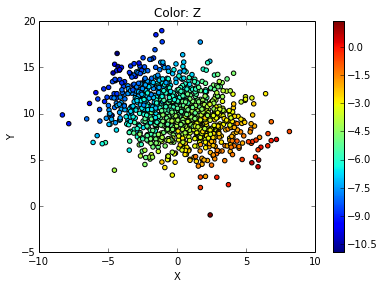

In [2]:
%matplotlib inline
from matplotlib import cm
import matplotlib.pyplot as plt

import scipy as sp
import scipy.stats as sts
import numpy as np


n_samples = 1000

W = sts.norm.rvs(loc=5, scale = 1, size = [n_samples,1])
Z = sts.norm.rvs(loc=-5, scale = 2, size = [n_samples,1])
X = W + Z + sts.norm.rvs(loc=0, scale = 1, size = [n_samples,1])
Y = X - 2*Z + sts.norm.rvs(loc=0, scale = 1, size = [n_samples,1])

fig = plt.figure()

axes = fig.add_axes([0.1, 0.1, 0.8, 0.8]) # left, bottom, width, height (range 0 to 1)

sc = axes.scatter(X,Y, s=20,c=Z, marker = 'o', cmap = cm.jet )
plt.colorbar(sc)

axes.set_ylabel('Y')
axes.set_xlabel('X')
axes.set_title('Color: Z')

## Regression coefficients with control

In [3]:
from sklearn import linear_model

x_pred = np.arange(-10,10,0.1).reshape(-1,1)

# Simple Linear Regression
regr = linear_model.LinearRegression()
regr.fit(X,Y)
b_x = regr.coef_
y_pred_x = regr.predict(x_pred)

# Multiple Linear Regression (controlled for Z)
regr = linear_model.LinearRegression()
regr.fit(np.hstack((X,Z)),Y)
b_x_gZ = regr.coef_
# y_pred_x_gZ = regr.predict(x_pred)

# Multiple Linear Regression (controlled for W,Z)
regr = linear_model.LinearRegression()
regr.fit(np.hstack((X,W,Z)),Y)
b_x_gZW = regr.coef_
# y_pred_x_gZW = regr.predict(x_pred)

print 'Beta_x without control:\n', b_x[0,0]
print '\nBeta_x controlled for Z:\n', b_x_gZ[0,0]
print '\nBeta_x controlled for Z, W:\n', b_x_gZW[0,0]

Beta_x without control:
-0.282166236537

Beta_x controlled for Z:
1.00937720145

Beta_x controlled for Z, W:
0.995089107364


As expected, controlling for $Z$ and for $Z,W$ result in the same regression coefficient for $X$

## Covariance Matrices: Marginal, Conditional, Precision

Direct computation of pairwise covariances of $\{X,Y,W,Z\}$ result in

$
\Sigma = \begin{bmatrix}
        6 & -2 & 1 &  4 \\
       -2 &  7 & 1 & -4 \\
        1 &  1 & 1 &  0 \\
        4 & -4 & 0 &  4 \\
        \end{bmatrix}
$

In [4]:
data = np.hstack((X,Y,W,Z))

Sigma = np.round(np.cov(data.T))
print 'Indeed, the (rounded) Empirical Covariance Matrix is \n', Sigma

Indeed, the (rounded) Empirical Covariance Matrix is 
[[ 6. -2.  1.  4.]
 [-2.  7.  1. -4.]
 [ 1.  1.  1.  0.]
 [ 4. -4.  0.  4.]]


### Precision
Entries $p_{ij}$ of the precision matrix $P = \Sigma^{-1}$ carry information on the partial correlation between variables $i$ and $j$ controlling for the remaining variables in $\Sigma$. 

In fact, both $\beta_j$ (OLS multiple regression coefficients) and $p_{yj}$ are partial correlations with different standardizations. Therefore, just as controlling for $Z$ or $Z,W$ did not change the regression coefficients, the corresponding precision entries should not change in the two cases.

In [4]:
def precision(Sigma):
    return np.linalg.inv(Sigma)

def submatrix(Sigma, index_list):
    return Sigma[np.ix_(index_list,index_list)]

P = precision(Sigma)
print '\nP over XYWZ\n', np.round(P)

P_XYZ = precision(submatrix(Sigma, [0,1,3]))
print '\nP over XYZ\n', P_XYZ


P over XYWZ
[[ 2. -1. -1. -3.]
 [-1.  1.  0.  2.]
 [-1.  0.  2.  1.]
 [-3.  2.  1.  5.]]

P over XYZ
[[ 1.5  -1.   -2.5 ]
 [-1.    1.    2.  ]
 [-2.5   2.    4.75]]


Of interest are $p_{01}=-1$ in both matrices.

### Conditioning
We can directly compute conditional covariance matrices as

$\Sigma_{XY|Z} = \Sigma_{XY}-\Sigma_{XY.Z}\Sigma_{Z}^{-1}\Sigma_{Z.XY}$

Analogously, I would expect that $(\Sigma_{XY|Z})_{xy} = (\Sigma_{XY|WZ})_{xy}$

In [24]:
def conditional_cov(Sigma, targets, givens):
    subSigma_targets = submatrix(Sigma, targets)
    subSigma_givens = submatrix(Sigma, givens)
    subSigma_rest = Sigma[np.ix_(targets, givens)]
    
#     print 'Sigma\n', Sigma
#     print '\nsubSigma_targets \n', subSigma_targets
#     print '\n subSigma_givens\n', subSigma_givens
#     print '\n subSigma_rest \n', subSigma_rest
    
    return subSigma_targets - subSigma_rest.dot(np.linalg.pinv(subSigma_givens).dot(subSigma_rest.T))

print 'Sigma XY given Z\n', conditional_cov(Sigma, [0,1], [3])

print '\nSigma XY given WZ\n', conditional_cov(Sigma, [0,1], [2,3])

Sigma XY given Z
[[ 2.  2.]
 [ 2.  3.]]

Sigma XY given WZ
[[ 1.  1.]
 [ 1.  2.]]


This is not currently the case and will demand further debugging.

## Analytic CMIs
I tried to check whether similar results hold for conditional mutual information. In the multivariate normal case, it is possible to analytically compute CMI, by decomposing it in differential entropies. We obtain the following equivalent formulas:


$$CMI(X;Y|Z) = \frac{1}{2} \log (\frac{|\Sigma_{X|Z}| |\Sigma_{Y|Z}|} {|\Sigma_{XY|Z}|})=
\frac{1}{2} \log (\frac{|\Sigma_{XZ}| |\Sigma_{YZ}|} {|\Sigma_{XYZ}||\Sigma_{WZ}|})$$

I expected that $CMI (X;Y|Z) = CMI(X;Y|W,Z)$

In [5]:
from numpy.linalg import det

def CMI(Sigma,X,Y,givens):
    '''Compute CMI(X;Y|givens) for {X,Y,givens} jointly gaussian distributed
        Sigma - multivariate covariance matrix
        X - column index of first target
        Y - column index of second target
        givens - list of column indexes of variables to condition on
    ''' 
    Sigma_Xgivens = submatrix(Sigma,[X] + givens)
    Sigma_Ygivens = submatrix(Sigma,[Y] + givens)
    Sigma_tot = submatrix(Sigma, [X,Y] + givens)
    Sigma_givens = submatrix(Sigma,givens)

    return .5*np.log( det(Sigma_Xgivens) * det(Sigma_Ygivens) / (det(Sigma_tot) * det(Sigma_givens) ))

print 'CMI(X;Y|Z) = ', CMI(Sigma,0,1,[3])
print '\nCMI(X;Y|W,Z) = ', CMI(Sigma,0,1,[2,3])
print '\nCMI(W;Y|Z) = ', CMI(Sigma,2,1,[3])

CMI(X;Y|Z) =  0.549306144334

CMI(X;Y|W,Z) =  0.34657359028

CMI(W;Y|Z) =  0.202732554054


As this was not the case, I tried to compute it using the alternative formula, as a debug attempt.

In [26]:
def alt_CMI(Sigma, X, Y, givens):
    '''
    
    '''
    Sigma_Xbargivens = conditional_cov(Sigma, [X], givens)
    Sigma_Ybargivens = conditional_cov(Sigma, [Y], givens)
    Sigma_XYbargivens = conditional_cov(Sigma, [X,Y], givens)
    
    return - .5 * np.log( det(Sigma_XYbargivens) / (det(Sigma_Xbargivens)* det(Sigma_Ybargivens)))

print 'CMI(X;Y|Z) = ', alt_CMI(Sigma,0,1,[3])
print '\nCMI(X;Y|W,Z) = ', alt_CMI(Sigma,0,1,[2,3])

CMI(X;Y|Z) =  0.549306144334

CMI(X;Y|W,Z) =  0.34657359028


### Conclusion: Direct CMI does not work as a control (?)

## EXTRA: Test CMI formula with conditionally independent X, Y

Remove direct effect from X on Y in the Structural Equation Model

$W \leftarrow \mathcal{N}(5,1)$

$Z \leftarrow \mathcal{N}(-5,2)$

$X \leftarrow W + Z + \mathcal{N}(0,1)$

$Y \leftarrow - 2 \times Z + \mathcal{N}(0,1)$

Expected: $CMI(X,Y|Z) = CMI(X,Y|W,Z) = 0$

In [28]:
n_samples = 1000

W = sts.norm.rvs(loc=5, scale = 1, size = [n_samples,1])
Z = sts.norm.rvs(loc=-5, scale = 2, size = [n_samples,1])
X = W + Z + sts.norm.rvs(loc=0, scale = 1, size = [n_samples,1])
Y = - 2*Z + sts.norm.rvs(loc=0, scale = 1, size = [n_samples,1])

data = np.hstack((X,Y,W,Z))

#                   X, Y, W, Z
Sigma = np.array([[ 6,-8,1, 4],
                  [-8,16,0,-8],
                  [ 1, 0,1, 0],
                  [ 4,-8,0, 4]])

print 'CMI(X;Y|Z) = ', CMI(Sigma,0,1,[3])
print '\nCMI(X;Y|W,Z) = ', CMI(Sigma,0,1,[2,3])

CMI(X;Y|Z) =  nan

CMI(X;Y|W,Z) =  nan


/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:15: RuntimeWarning: invalid value encountered in double_scalars


Singular matrices inside the log lead to null determinant.

However, under machine precision,

In [10]:
Sigma = np.cov(data.T)

print 'CMI(X;Y|Z) = ', CMI(Sigma,0,1,[3])
print '\nCMI(X;Y|W,Z) = ', CMI(Sigma,0,1,[2,3])

CMI(X;Y|Z) =  0.000329851327849

CMI(X;Y|W,Z) =  0.00159726557239
